In [669]:
# IMPORT LIBRARIES
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split, cross_validate
from AI.algorithms_from_scratch.data_plotting import Plots
from sklearn.base import BaseEstimator, RegressorMixin

In [670]:
# CREATE DATA
X, y = make_regression(n_samples=1_000, n_features=1, noise=10, random_state=42)

In [671]:
print(X)

[[-1.75873949e+00]
 [ 1.03184454e+00]
 [-4.87606224e-01]
 [ 1.86454315e-01]
 [ 7.25766624e-01]
 [ 9.72554450e-01]
 [ 6.45375950e-01]
 [ 6.81891490e-01]
 [-1.43014138e+00]
 [ 1.06667469e+00]
 [ 1.55050049e+00]
 [-1.55677235e-01]
 [-2.69874935e-01]
 [-2.30192116e+00]
 [-1.86726519e+00]
 [-7.44334291e-02]
 [ 5.88317206e-01]
 [ 1.20650897e+00]
 [-1.92360965e-01]
 [ 1.11957491e+00]
 [-3.09546439e-01]
 [-1.28030440e+00]
 [ 1.30714275e+00]
 [ 1.17944012e+00]
 [ 8.65897875e-02]
 [ 4.73832921e-01]
 [ 4.29618219e-01]
 [ 4.89374561e-01]
 [-1.40746377e+00]
 [-5.03475654e-01]
 [-5.52223044e-01]
 [-8.22220396e-01]
 [ 1.54993441e+00]
 [ 5.76556963e-01]
 [ 2.32049937e-01]
 [ 3.38496407e-01]
 [-3.76347024e-02]
 [-8.15810285e-01]
 [-1.42474819e+00]
 [-4.69175652e-01]
 [-4.78748622e-01]
 [ 3.24166352e-01]
 [ 9.15402118e-01]
 [ 7.10959968e-01]
 [-4.63417693e-01]
 [ 9.63376129e-01]
 [-7.55382932e-01]
 [ 1.79455786e+00]
 [ 5.77072127e-01]
 [-9.07563662e-01]
 [-4.40044487e-01]
 [-4.59360900e-01]
 [ 3.6659824

In [672]:
y

array([-3.27703860e+01,  3.50459106e+00, -1.79303077e+01, -3.99020124e+00,
        1.31052643e+01,  3.37844061e+01, -6.56837449e+00,  3.03343732e+01,
       -1.61515953e+01,  6.88348836e+00,  3.77299337e+01, -1.35859461e+01,
       -5.34641296e+00, -5.25582497e+01, -2.85959274e+01, -3.81250959e+00,
        1.01659573e+01,  2.26026891e+01, -1.24605121e+00,  7.68784791e+00,
        7.06695978e+00, -2.15775869e+01,  3.74179825e+01,  9.94439327e+00,
        4.99801294e+00, -7.39208241e+00,  4.99341060e+00,  1.81230569e+01,
       -2.67390670e+01, -1.77695628e+01, -1.19064700e+01, -2.42104879e+01,
        2.33447024e+01,  1.24361555e+01, -7.82398627e+00, -7.66234787e+00,
       -1.27512146e+01, -2.35061251e+01, -1.63287929e+01, -2.11370557e+01,
       -5.33159127e+00, -2.34534903e+01,  1.40222313e+01,  5.28020342e+00,
       -9.74097045e+00,  1.36080153e+01, -2.12908606e+01,  2.84422764e+01,
       -1.90478736e+01, -2.40605351e+01, -6.61810782e+00, -1.19610661e+01,
        5.19616459e+00,  

In [673]:
# # SORT DATA
# Sort X and get the sorted indices
sorted_indices = np.argsort(X.ravel())

# Sort X and y based on the sorted indices
X = X[sorted_indices]
y = y[sorted_indices]

In [674]:
print(X)

[[-3.24126734e+00]
 [-2.69688664e+00]
 [-2.65096981e+00]
 [-2.61974510e+00]
 [-2.47164450e+00]
 [-2.42387933e+00]
 [-2.30192116e+00]
 [-2.21113531e+00]
 [-2.19880596e+00]
 [-2.12389572e+00]
 [-2.08192941e+00]
 [-2.07339023e+00]
 [-2.06744210e+00]
 [-2.04173487e+00]
 [-2.03923218e+00]
 [-2.03812454e+00]
 [-2.02514259e+00]
 [-1.98756891e+00]
 [-1.95967012e+00]
 [-1.95208780e+00]
 [-1.91877122e+00]
 [-1.91328024e+00]
 [-1.88954073e+00]
 [-1.87079192e+00]
 [-1.86726519e+00]
 [-1.84087423e+00]
 [-1.80488210e+00]
 [-1.77872025e+00]
 [-1.76304016e+00]
 [-1.75873949e+00]
 [-1.72491783e+00]
 [-1.71313453e+00]
 [-1.71016839e+00]
 [-1.70338244e+00]
 [-1.70258360e+00]
 [-1.69246463e+00]
 [-1.66940528e+00]
 [-1.66152006e+00]
 [-1.66096093e+00]
 [-1.65485667e+00]
 [-1.62754244e+00]
 [-1.61271587e+00]
 [-1.60748323e+00]
 [-1.60644632e+00]
 [-1.59442766e+00]
 [-1.58390282e+00]
 [-1.57022472e+00]
 [-1.55662917e+00]
 [-1.55066343e+00]
 [-1.53411417e+00]
 [-1.52552517e+00]
 [-1.52318690e+00]
 [-1.5193699

In [675]:
y

array([-4.11454876e+01, -4.78236223e+01, -2.64699010e+01, -3.54053774e+01,
       -3.93388766e+01, -4.65341585e+01, -5.25582497e+01, -4.30727879e+01,
       -1.91350029e+01, -4.19764884e+01, -5.42298445e+01, -2.87612516e+01,
       -4.50140724e+01, -3.55431886e+01, -3.57992178e+01, -3.31185931e+01,
       -4.49254038e+01, -2.03009324e+01, -1.50127691e+01, -4.40086008e+01,
       -2.25064205e+01, -1.02190414e+01, -2.44899336e+01, -4.89608310e+01,
       -2.85959274e+01, -3.99384752e+01, -3.32708703e+01, -3.62628724e+01,
       -3.24427516e+01, -3.27703860e+01, -3.25845854e+01, -2.18893657e+01,
       -5.14122539e+01, -1.63913746e+01, -2.53455157e+01, -1.52511057e+01,
       -9.34157290e+00, -3.95722723e+01, -4.98957118e+01, -1.40317473e+01,
       -1.52720873e+01, -4.38632912e+01, -4.24498150e+01, -3.50770325e+01,
       -2.38784509e+01, -1.95565849e+01, -1.84698266e+01, -3.11627798e+01,
       -1.55017103e+01, -3.15273200e+01, -1.91520162e+01, -1.42371452e+01,
       -2.44824633e+01, -

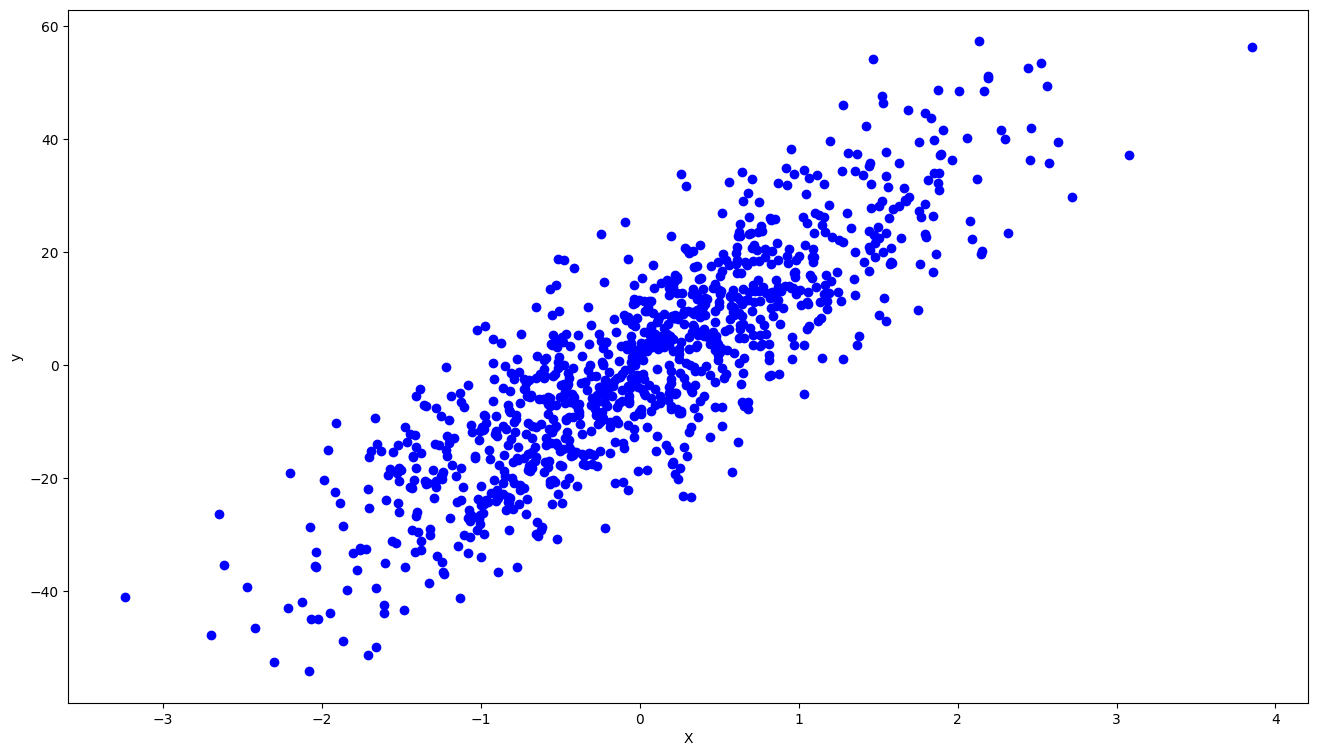

In [676]:
# PLOT DATA
plt.figure(figsize=(16, 9))
plt.plot(X, y, 'bo')
plt.xlabel('X')
plt.ylabel('y')
plt.show()

In [677]:
# SPLIT DATA
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [678]:
# DECISION TREE REGRESSION
import numpy as np
from sklearn.base import BaseEstimator, RegressorMixin

class MyDecisionTreeRegressor(BaseEstimator, RegressorMixin):
    def __init__(self, min_samples_split: int = 2, max_depth: int = 10):
        """
        Initialize the MyDecisionTreeRegressor with specified parameters.

        :param min_samples_split: The minimum number of samples required to split an internal node.
        :param max_depth: The maximum depth of the tree.
        """
        self.min_samples_split = min_samples_split
        self.max_depth = max_depth
        self.tree: 'MyDecisionTreeRegressor.Node' = None

    class Node:
        """
        A class representing a single node in the decision tree.

        :param feature_column_index: The index of the feature column used for splitting at this node.
        :param threshold: The threshold value used to split the feature at this node.
        :param left: The left child node.
        :param right: The right child node.
        :param value: The predicted value if the node is a leaf, otherwise None.
        """

        def __init__(self,
                     feature_column_index: int = None,
                     threshold: float = None,
                     left: 'MyDecisionTreeRegressor.Node' = None,
                     right: 'MyDecisionTreeRegressor.Node' = None,
                     value: float = None):
            self.feature_column_index = feature_column_index
            self.threshold = threshold
            self.left = left
            self.right = right
            self.value = value

    def fit(self, X: np.ndarray, y: np.ndarray):
        """
        Fit the decision tree regressor on the training data.

        :param X: The training input samples.
        :param y: The target values (continuous values).
        :return: Fitted estimator.
        """
        self.tree = self._grow_tree(X, y)
        return self

    def predict(self, X: np.ndarray):
        """
        Predict values for samples in X.

        :param X: The input samples.
        :return: The predicted values.
        """
        return np.array([self._predict_input(x, self.tree) for x in X])

    def _grow_tree(self, X: np.ndarray, y: np.ndarray, depth: int = 0):
        """
        Recursively grow the decision tree.

        :param X: The input samples.
        :param y: The target values (continuous values).
        :param depth: The current depth of the tree.
        :return: The root node of the decision tree.
        """
        nr_samples, nr_features = X.shape

        # Stopping conditions
        if (depth >= self.max_depth
                or nr_samples < self.min_samples_split):
            value = self._calculate_mean(y)
            return self.Node(value=value)

        # Find the best split
        best_mse = float('inf')
        best_feature_column_index = None
        best_threshold = None

        for feature_column_index in range(nr_features):
            feature_column = X[:, feature_column_index]
            thresholds = np.unique(feature_column)
            for threshold in thresholds:
                mse = self._calculate_weighted_mse(feature_column, y, threshold)
                if mse < best_mse:
                    best_mse = mse
                    best_feature_column_index = feature_column_index
                    best_threshold = threshold

        if best_mse == float('inf'):
            value = self._calculate_mean(y)
            return self.Node(value=value)

        # Grow the children
        left_indices = X[:, best_feature_column_index] <= best_threshold
        right_indices = X[:, best_feature_column_index] > best_threshold
        left_subtree = self._grow_tree(X[left_indices], y[left_indices], depth + 1)
        right_subtree = self._grow_tree(X[right_indices], y[right_indices], depth + 1)
        return self.Node(best_feature_column_index, best_threshold,
                         left_subtree, right_subtree)

    def _calculate_weighted_mse(self, feature_column: np.ndarray, y: np.ndarray, threshold: float):
        """
        Calculate the weighted mean squared error (MSE) for a potential split.

        :param feature_column: The feature values for the samples.
        :param y: The target values (continuous values).
        :param threshold: The threshold value to split the feature.
        :return: The weighted mean squared error for the split.
        """
        left_indices = feature_column <= threshold
        right_indices = feature_column > threshold

        if len(left_indices) == 0 or len(right_indices) == 0:
            return float('inf')

        left_mse = self._calculate_mse(y[left_indices])
        right_mse = self._calculate_mse(y[right_indices])
        left_weight = len(y[left_indices]) / len(y)
        right_weight = len(y[right_indices]) / len(y)
        return left_weight * left_mse + right_weight * right_mse

    def _calculate_mse(self, y: np.ndarray):
        """
        Calculate the mean squared error (MSE) for a set of values.

        :param y: The target values (continuous values).
        :return: The mean squared error.
        """
        if len(y) == 0:
            return float('inf')
        mean = np.mean(y)
        mse = np.mean((y - mean) ** 2)
        return mse

    def _calculate_mean(self, y: np.ndarray):
        """
        Calculate the mean value of a set of values.

        :param y: The target values (continuous values).
        :return: The mean value.
        """
        return np.mean(y)

    def _predict_input(self, x: np.ndarray, node: 'MyDecisionTreeRegressor.Node'):
        """
        Predict the value for a single input using the trained tree.

        :param x: The input sample.
        :param node: The current node in the decision tree.
        :return: The predicted value for the input sample.
        """
        if node.value is not None:
            return node.value
        if x[node.feature_column_index] <= node.threshold:
            return self._predict_input(x, node.left)
        return self._predict_input(x, node.right)


In [679]:
# TRAIN MODEL
dc_reg = MyDecisionTreeRegressor(max_depth=4)
dc_reg.fit(X_train, y_train)

MyDecisionTreeRegressor(max_depth=4)

In [680]:
# PREDICT
y_pred = dc_reg.predict(X_test)

In [681]:
# CROSS VALIDATION
cv_results = cross_validate(dc_reg, X_train, y_train, cv=5, scoring='neg_mean_squared_error')
cv_results['test_score']

array([-109.24367467, -100.41695436, -121.69046212, -116.75180478,
       -100.19411531])

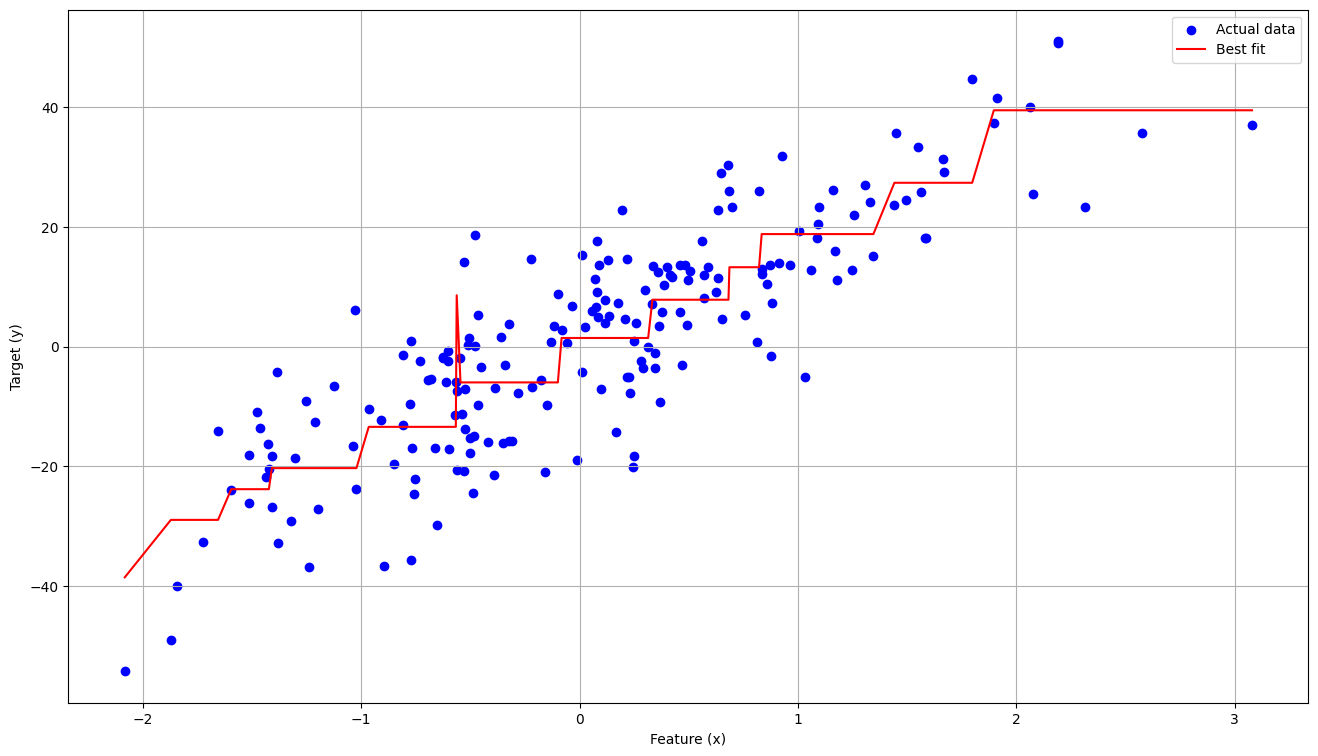

In [682]:
# Sort the data based on the feature to maintain the relationship
sort_indices = np.argsort(X_test.ravel())
X_test_sorted = X_test[sort_indices]
y_test_sorted = y_test[sort_indices]
y_pred_sorted = y_pred[sort_indices]

# Plot the data
fig = plt.figure(figsize=(16, 9))
plt.scatter(X_test_sorted, y_test_sorted, label="Actual data", color='b')
plt.plot(X_test_sorted, y_pred_sorted, label="Best fit", color='r')
plt.xlabel('Feature (x)')
plt.ylabel('Target (y)')
plt.legend()
plt.grid()
plt.show()